In [1]:
%load_ext autoreload
%autoreload 2
import io, os, re, logging, sys

sys.path.append("../")

import requests, tqdm, tarfile, itertools, html, time
from dateparser.date import DateDataParser
from dateparser import parse
from fuzzywuzzy import process, fuzz

import numpy as np
import pandas as pd
import dask.dataframe as dd

import torch
import torch.nn.functional as F
import pyro
import pyro.distributions as dist

import plotly.express as px
import plotly.graph_objects as go

from statsmodels.nonparametric.smoothers_lowess import lowess

from src.visualization.visualize import visualize_shot

# Import Dataset

In [2]:
shots_df = pd.read_parquet("../data/raw/visualizercoffee_73202shots_2021-12-29_cleaned.parquet")
shots_df['espresso_enjoyment'].replace({0.0: np.NaN}, inplace=True)
shots_df["yield_ratio"] = shots_df["drink_weight"] / shots_df["bean_weight"]
shots_df["max_pressure"] = shots_df["espresso_pressure"].apply(max)
shots_df["max_flow"] = shots_df["espresso_flow"].apply(max)

shots_df

,id,profile_title,user_id,drink_tds,drink_ey,espresso_enjoyment,bean_weight,drink_weight,grinder_model,grinder_setting,...,espresso_temperature_goal,espresso_resistance_weight,espresso_temperature_basket,duration,user_name,bean_age,shot_time,yield_ratio,max_pressure,max_flow
0,14899484-a5f8-4ccc-b372-79700c8150ae,TurboBloom,8d827d10-510f-4475-bd54-63c93b275c16,0.0,0.0,80.0,15.0,35.2,Lagom P64,1.4,...,"[86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[86.0, 85.12, 85.27, 85.49, 85.38, 85.35, 85.3...",NaN,None,NaN,18.493,2.346667,5.95,8.27
1,76f936ee-5147-40ac-986e-f0f1be5ac97e,Best overall pressure profile,10f1e281-8fd0-4f43-94f6-d416713dabe0,0.0,0.0,NaN,18.0,36.1,Bentwood 63,120.0,...,"[88.0, 88.0, 88.0, 88.0, 88.0, 88.0, 88.0, 88....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[88.0, 87.18, 87.39, 87.37, 87.31, 87.23, 87.0...",NaN,None,NaN,29.475,2.005556,8.38,4.11
2,8853ae7c-5bf8-4194-93dd-462de63f1471,Default,30b3dd10-aebb-4f17-ba74-a1efcf2d51ea,0.0,0.0,NaN,NaN,40.3,None,NaN,...,"[90.5, 90.5, 90.5, 90.5, 90.5, 90.5, 90.5, 90....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[90.5, 87.93, 88.21, 88.23, 88.16, 88.14, 88.1...",NaN,None,NaN,35.054,NaN,8.90,4.09
3,a4d7a358-fc3f-451c-92f5-756adaa4a7dd,Rao Allongé,c8c4793c-6708-4e81-90e8-6d8a5b30ceee,0.0,0.0,NaN,NaN,124.5,Niche Zero,13.5,...,"[92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[92.0, 90.0, 90.41, 90.36, 90.35, 90.44, 90.4,...",NaN,None,NaN,40.996,NaN,8.76,4.84
4,3ebcfff9-fb6f-47f6-a3df-affe01d55150,Londonium,db110ce3-77b7-4c92-9d18-1019c3841cc9,0.0,0.0,NaN,NaN,0.0,None,NaN,...,"[89.0, 89.0, 88.5, 88.5, 88.5, 88.5, 88.5, 88....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[89.0, 87.55, 87.81, 87.75, 87.76, 87.8, 87.74...",NaN,None,NaN,38.787,NaN,9.18,6.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73197,a68afc41-645d-46c6-bfce-3dc9bf95ed0b,Default,b51718ab-bc11-463d-be90-5538921b05e4,0.0,0.0,NaN,0.0,0.0,None,NaN,...,"[94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94....",None,"[94.0, 65.96, 65.81, 65.66, 65.48, 65.41, 65.2...",119.943,Christopher Wansing,NaN,119.943,NaN,8.97,6.74
73198,a37b6160-3e6a-4860-97cc-6b75a035c0da,Default,b51718ab-bc11-463d-be90-5538921b05e4,0.0,0.0,NaN,0.0,0.0,None,NaN,...,"[94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94....",None,"[94.0, 89.45, 89.35, 89.1, 88.84, 88.48, 88.2,...",119.739,Christopher Wansing,NaN,119.739,NaN,9.47,7.15
73199,3849dd2f-1678-488b-8f76-b166f53fe7ed,Gentle flat 2.5 ml per second,b51718ab-bc11-463d-be90-5538921b05e4,0.0,0.0,NaN,0.0,0.0,None,NaN,...,"[90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90....",None,"[90.0, 90.7, 90.7, 90.6, 90.57, 90.51, 90.46, ...",82.796,Christopher Wansing,NaN,82.796,NaN,0.48,2.05
73200,5a5d218e-7d84-4a8c-9621-f3067b0b8fb5,None,b51718ab-bc11-463d-be90-5538921b05e4,0.0,0.0,NaN,0.0,0.0,None,NaN,...,"[92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92....",None,"[92.0, 90.81, 90.82, 90.73, 90.65, 90.49, 90.4...",119.743,Christopher Wansing,NaN,119.743,NaN,6.28,7.33


In [3]:
shots_df.dtypes

id                                     object
profile_title                          object
user_id                                object
drink_tds                             float64
drink_ey                              float64
espresso_enjoyment                    float64
bean_weight                           float64
drink_weight                          float64
grinder_model                          object
grinder_setting                       float64
bean_brand                             object
bean_type                              object
roast_date                     datetime64[ns]
espresso_notes                         object
roast_level                            object
bean_notes                             object
start_time                     datetime64[ns]
image_preview                          object
profile_url                            object
timeframe                              object
espresso_flow                          object
espresso_weight                   

# Exploring grind setting in Niche Zero grinders

In [21]:
# Most popular grinders in all 78000 shots
shots_df["roast_date"]

0       2021-03-11
1              NaT
2       2020-02-23
3       2021-06-10
4              NaT
           ...    
73197          NaT
73198          NaT
73199          NaT
73200          NaT
73201          NaT
Name: roast_date, Length: 73202, dtype: datetime64[ns]

In [36]:
# Most popular grinder settings
shots_df.groupby(["grinder_model"])["grinder_setting"].value_counts().sort_values(ascending=False)[:30]

grinder_model          grinder_setting
Niche Zero             12.00              812
                       13.00              806
                       14.00              785
                       17.00              689
                       15.00              678
                       11.00              604
                       10.00              520
                       16.00              508
                       18.00              405
Baratza Forté          1.00               385
Niche Zero             19.00              319
Bentwood 63            130.00             315
Niche Zero             8.00               297
                       9.00               286
Sette 270              7.00               268
                       5.00               267
                       4.00               258
Lagom P64              8.90               257
Niche Zero             12.50              245
                       7.00               237
                       13.50             

In [22]:
niche_shots = shots_df[shots_df["grinder_model"] == "Niche Zero"]
niche_shots.shape

(11059, 41)

## Grindsize vs shot time

### Since shot time is dependent on the profile, we look at Grindsize vs shot time for the top 5 profiles independently

In [37]:
most_popular_profiles = shots_df["profile_title"].value_counts()
most_popular_profiles.head()

Default             5158
Damian's LRv3       5101
Londonium           3806
Damian's LRv2       3657
Gentle and sweet    3209
Name: profile_title, dtype: int64

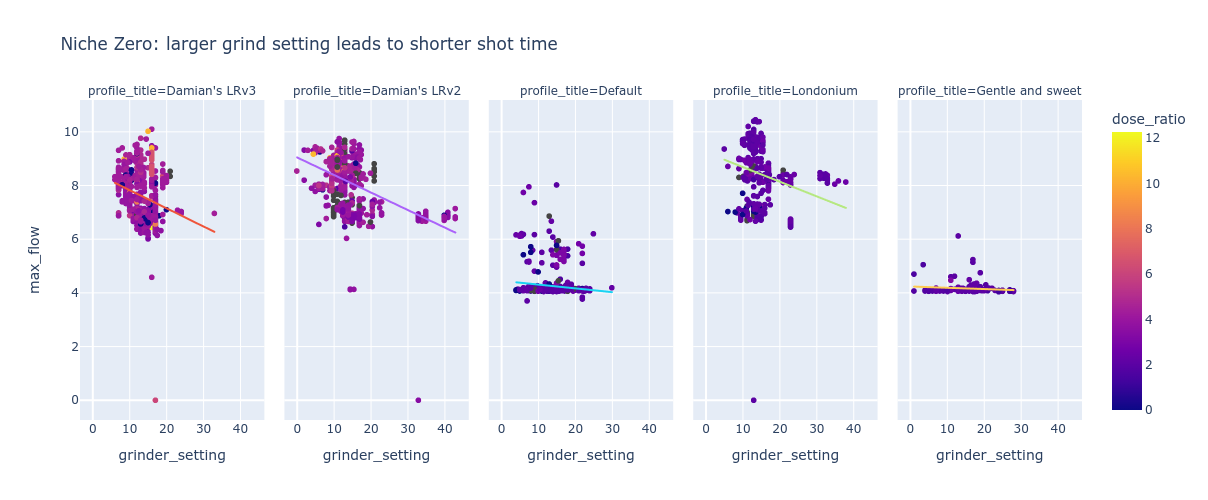

In [47]:
df = niche_shots[niche_shots["profile_title"].isin(most_popular_profiles.index[:5]) \
                 # & niche_shots["bean_age"].notnull() \
                 # & niche_shots["dose_ratio"].notnull()
                ]

fig = px.scatter(df, 
                 x='grinder_setting', y='max_flow', 
                 facet_col='profile_title', 
                 color="dose_ratio", 
                 # range_color=(0, 50),
                 trendline="ols",
                 title='Niche Zero: larger grind setting leads to shorter shot time',
                 height=500, width=1200,
                 )

fig
# .show(renderer="png")